**Домашнее задание «Модели авторегрессии условной гетероскедантичности»**

In [ ]:
!pip install pmdarima

In [ ]:
!pip install arch

In [108]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from pmdarima import auto_arima
from arch import arch_model
import statistics as st

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [111]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [112]:
births = pd.read_csv('daily-total-female-births-in-cal.csv')
births

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [113]:
births.shape

(365, 2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


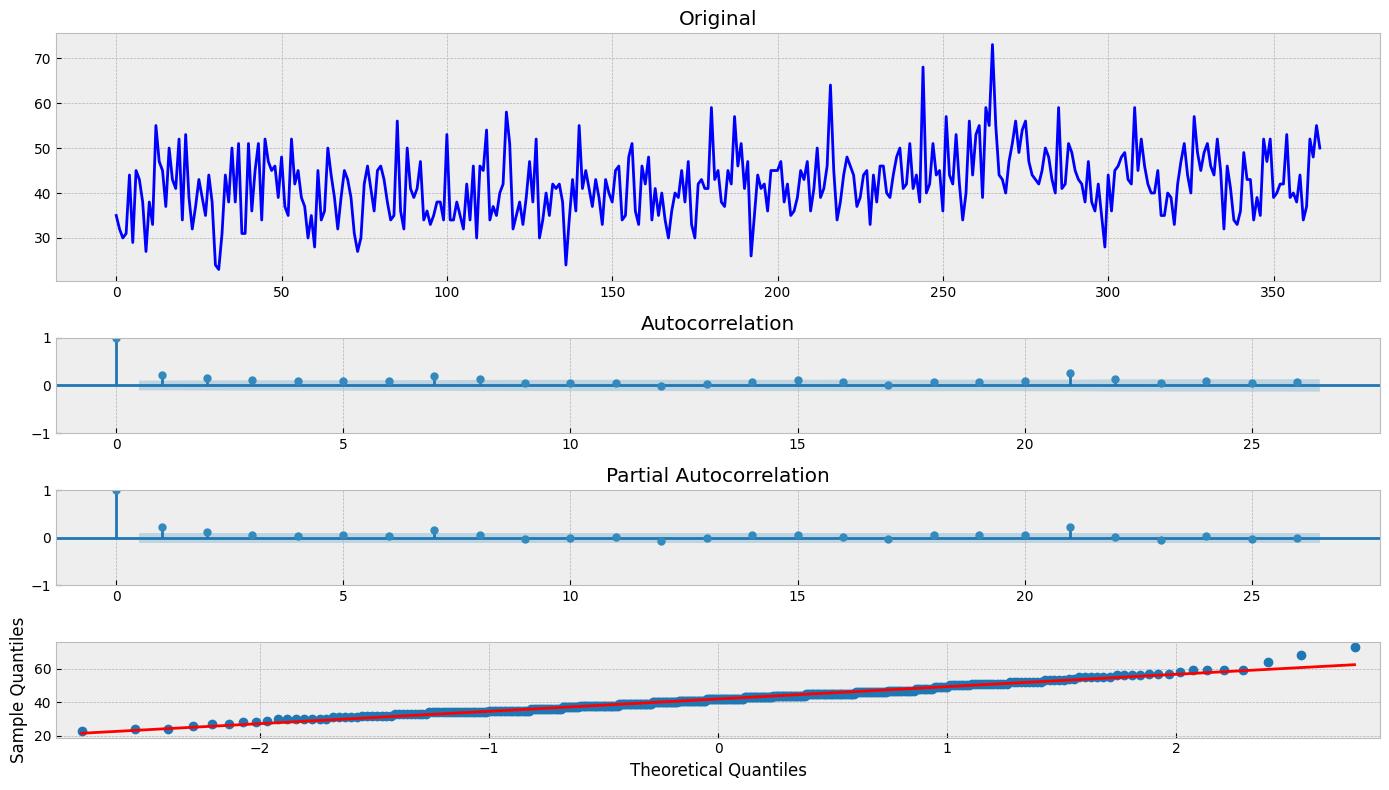

In [114]:
tsplot(births['Count'])

In [ ]:
# Ряд похож на стационарный, но по графикам автокорреляции и квантилей есть сомнения.

In [115]:
series = boxcox(births['Count'], 0)
series = np.diff(series, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


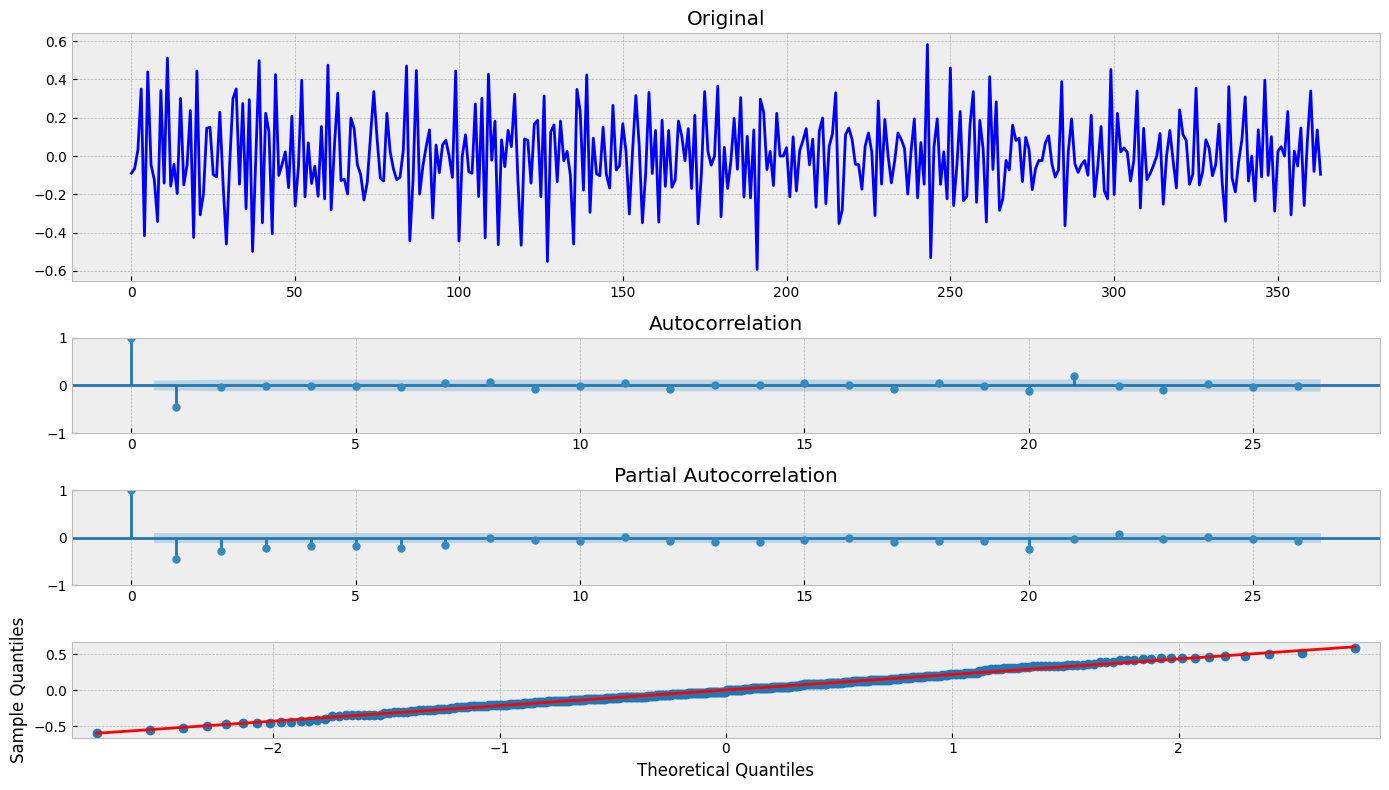

In [116]:
tsplot(series)

In [117]:
#Найдём лучшую модель

In [118]:
model_best = auto_arima(series, trace=True, suppress_warnings=True)
model_best.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-257.196, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-76.250, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-154.174, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-255.011, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-78.243, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-259.231, Time=1.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-260.306, Time=0.69 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-259.551, Time=1.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-261.061, Time=1.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-181.656, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-261.647, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-256.095, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-156.148, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 133.824
Date:                Tue, 12 Sep 2023   AIC                           -261.647
Time:                        11:32:45   BIC                           -249.956
Sample:                             0   HQIC                          -257.001
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1495      0.055      2.700      0.007       0.041       0.258
ma.L1         -0.9666      0.017    -57.947      0.000      -0.999      -0.934
sigma2         0.0279      0.002     14.235      0.000       0.024       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.84   Prob(JB):                         0.64
Heteroskedasticity (H):               0.71   Skew:                             0.05
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
arima_order = model_best.order
arima_order

(1, 0, 1)

In [120]:
# Разделим модель на обучающую и тестовую выборки

In [121]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
train_size

291

In [ ]:
# Построим модель GARCH

In [122]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = arima_order[0]
o_ = arima_order[1]
q_ = arima_order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: -22.078812412649473
Iteration:     10,   Func. Count:     70,   Neg. LLF: -23.549540193747657
Iteration:     15,   Func. Count:    100,   Neg. LLF: -23.961651179631048
Optimization terminated successfully    (Exit mode 0)
            Current function value: -23.96178896577073
            Iterations: 17
            Function evaluations: 123
            Gradient evaluations: 17
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                23.9618
Distribution:      Standardized Student's t   AIC:                          -37.9236
Method:                  Maximum Likelihood   BIC:                          -19.5570
                                              No. Observa

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -1.257551e+01
p-value                        1.961461e-23
#Lags Used                     6.000000e+00
Number of Observations Used    2.840000e+02
Critical Value (1%)           -3.453587e+00
Critical Value (5%)           -2.871771e+00
Critical Value (10%)          -2.572222e+00
dtype: float64


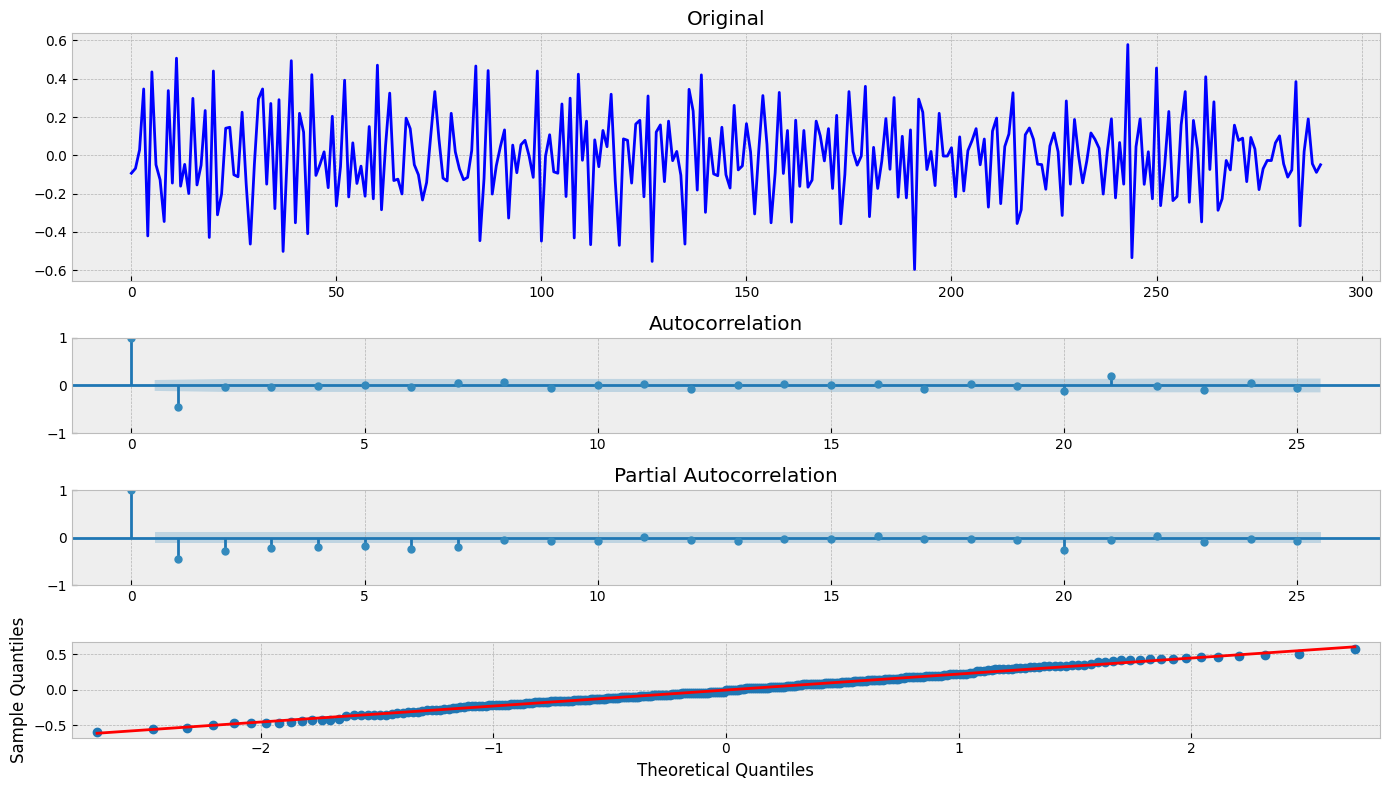

In [123]:
tsplot(res.resid)

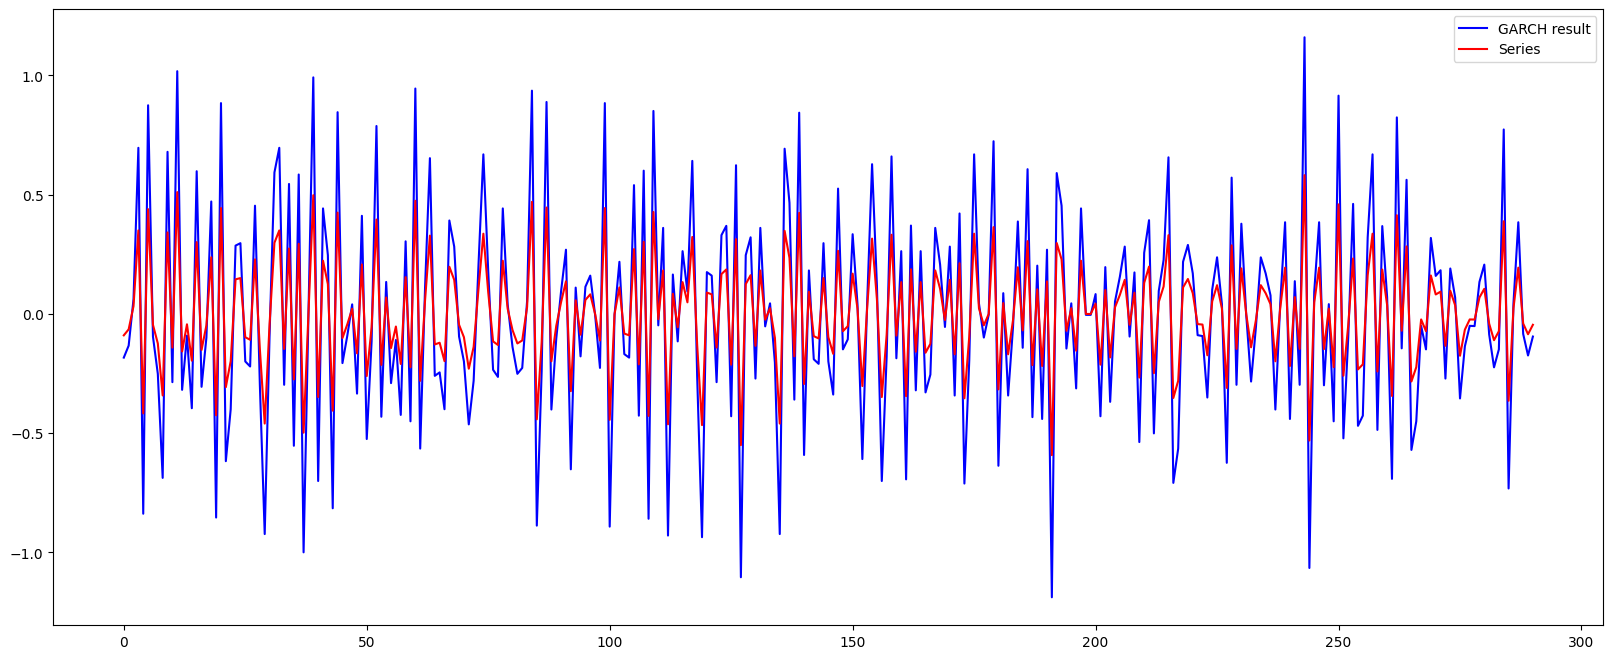

In [124]:
garch_res = train + res.resid

plt.figure(figsize=(20,8))
ax = plt.axes()
plt.plot(garch_res, color='blue', label='GARCH result')
plt.plot(train, color='red', label='Series')
plt.legend()
plt.show()

In [125]:
pred = res.forecast(horizon=len(test), method='simulation', simulations=1000, reindex = False)

In [126]:
var = [test[i + 1] - test[i] for i in range (len(test)-1)]

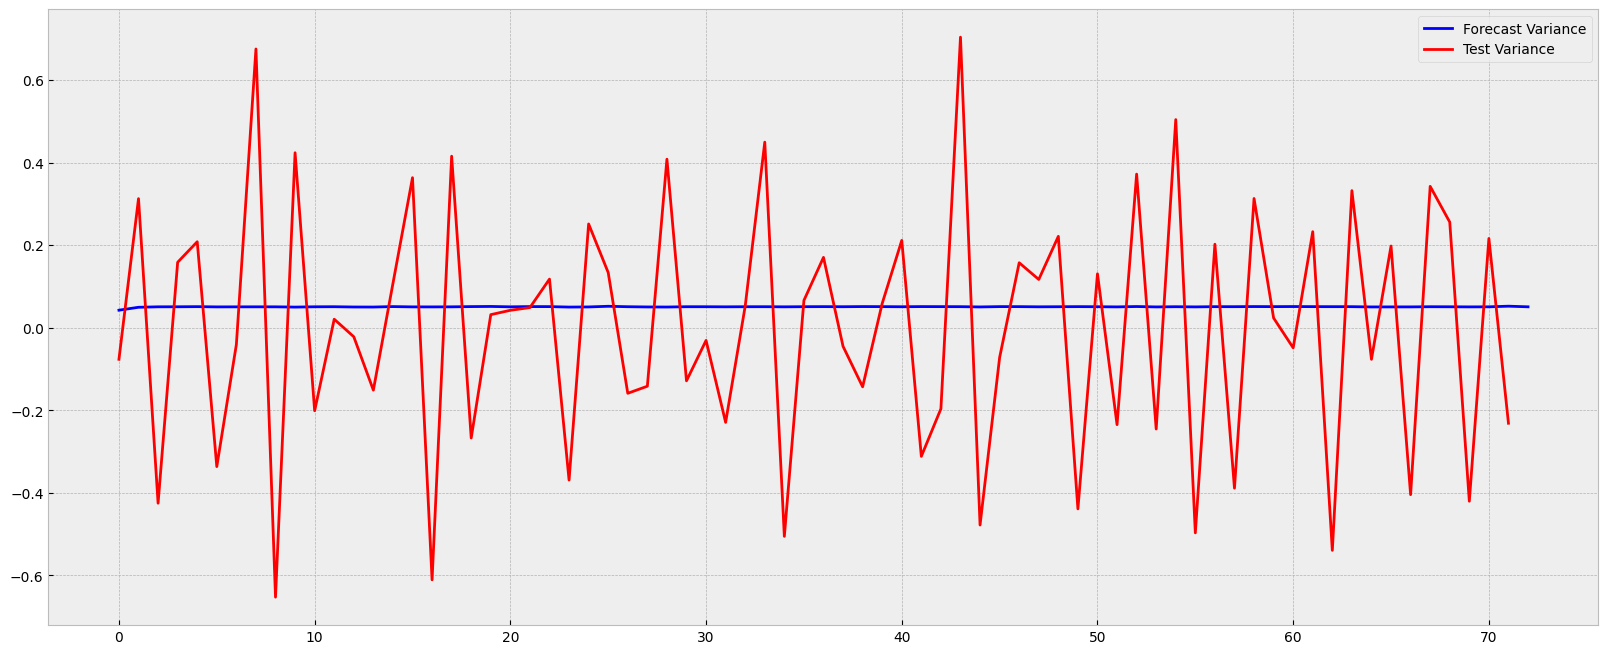

In [127]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plt.plot(pred.variance.values[-1, :], color='blue', label='Forecast Variance')
    plt.plot(var, color='red', label='Test Variance')
    plt.legend()
    plt.show()

Дополнительно. Построим модель линейной регрессии.

In [128]:
s = pd.DataFrame(births['Count'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s.loc[:, f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,38,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0,32.0,35.0
11,33,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0,32.0
12,55,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0
13,47,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0
14,45,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0


In [129]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data['lag_{}'.format(i)] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(['Date'], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(['Count'], axis=1)
    y_train = data.loc[:test_index]['Count']
    X_test = data.loc[test_index:].drop(['Count'], axis=1)
    y_test = data.loc[test_index:]['Count']

    return X_train, X_test, y_train, y_test

In [138]:
X_train, X_test, y_train, y_test = prepareData(births, lag_start=1, lag_end=14, test_size=0.2)

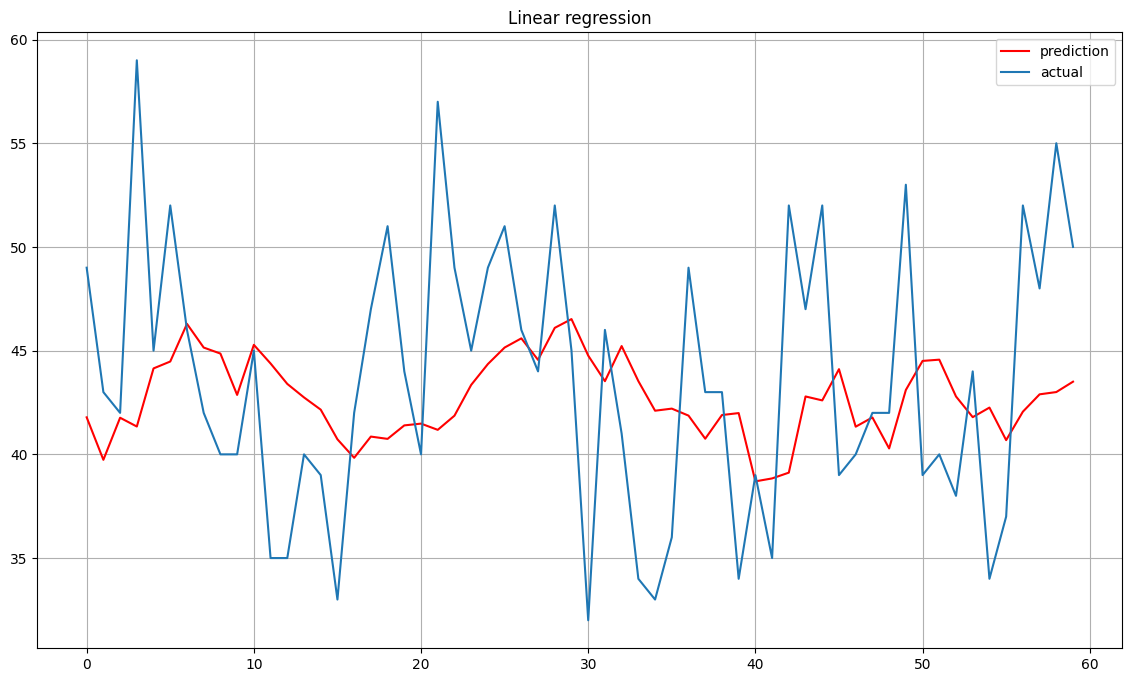

In [139]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [ ]:
# Предсказывать рождаемость довольно непростая задача)